In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target'] 
X.shape  # 7000 observations, 784 features (each feature is one pixel intensity, because the images are 28x28)

(70000, 784)

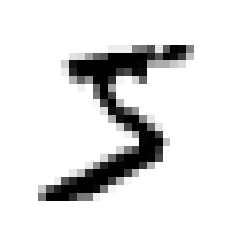

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# instead of some_digit = X[0]
some_digit = X.to_numpy()[0]  # new method to grab an instance
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]  # it is indeed a 5 as it looks like

'5'

In [5]:
import numpy as np

y = y.astype(np.uint8)

In [6]:
# the MNIST dataset is already split in training and test: the first 60000 are training and the rest is testing data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
print('training set has {} instances'.format(len(X_train)))
print('test set has {} instances'.format(len(X_test)))

training set has 60000 instances
test set has 10000 instances


In [8]:
y[0]

5

## Starting from a binary classifier which distinguishes not-5s and 5s

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_train_5

0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool

# SGD Classifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)  # train on whole training set
sgd_clf.predict([some_digit])  # some_digit is the first observation (all 784 features of 1st observation)

array([ True])

True prediction means "yes, it is a 5"

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# since it's 3-fold cross validation, I will have 3 different scores, one for each fold when used as test set

array([0.95035, 0.96035, 0.9604 ])

Each score is an "accuracy" score, namely the ratio of correct predictions

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)  # predicts all False (zeros as booleans)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

This very dumb classifier which always predicts "not 5" (False), still has high accuracy

## Accuracy is not the best performance measure in classification
### especially with *skewed* datasets

In [13]:
from sklearn.model_selection import cross_val_predict

# instead of returning scores, it returns predictions made on each test fold
# basically it returns the prediction of each training observation when it was on test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
print(y_train_pred)

[ True False False ...  True False False]


In [14]:
y_train_pred.shape  # we have 60000 "clean" predictions as expected

(60000,)

### CONFUSION MATRIX

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# note that rows are actual classes and columns are predicted
# 0,0 is TN  --> instances correctly classified as not 5s
# 1,0 is FN  --> instances wrongly classified as not 5s
# 0,1 is FP  --> instances wrongly classified as 5s
# 1,1 is TP  --> instances correctly classified as 5s

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [16]:
y_train_perfect_pred = y_train_5  # pretend we reached perfect predictions
confusion_matrix(y_train_5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

when all non zero elements are on the main diagonal, it means we only have either true negatives or true positives,\
and no false negatives nor false positives. --> PERFECT CLASSIFIER

## Precision
accuracy of positive predictions
## Recall
sensitivity or true positive rate, which means the percentage of positives actually captured by the model

In [17]:
from sklearn.metrics import precision_score, recall_score

# precision score is TP / (TP + FP)
ps = precision_score(y_train_5, y_train_pred)
print('precision score is ', ps)

# recall score is TP / (TP + FN)
rs = recall_score(y_train_5, y_train_pred)
print('recall score is ', rs)

precision score is  0.8370879772350012
recall score is  0.6511713705958311


In [18]:
print('when the model claims to have detected a 5, it is correct {} % of the times'.format(ps*100))
print('the model captured {} % of the 5s'.format(rs*100))

when the model claims to have detected a 5, it is correct 83.70879772350011 % of the times
the model captured 65.11713705958311 % of the 5s


for example, if I only make 1 correct predictions I have 100% precision, but I will just ignore
all others positives that I should have captured

## F1 Score
harmonic mean of precision and recall, useful to compare two classifier.\
The harmonic mean gives more weight to low values, so the F1 Score will be high
if both precision and recall are high.

In [19]:
from sklearn.metrics import f1_score

# f1 score is TP / (TP + (FN+FP)/2)
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifier with similar precision and recall.\
But in some cases we might be more interested in precision or recall only.

### Decision Scores

In [20]:
# accessing decision function returns a score for each instance, to be compared to threshold

y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

theshold = 0  # with threshold 0 we have ...
y_some_digit_pred = (y_scores > theshold)
print(y_some_digit_pred)

theshold = 8000  # raising threshold decreases recall and increases precision
y_some_digit_pred = (y_scores > theshold)
print(y_some_digit_pred)  # in this case the classifier fails to detect a 5

[2164.22030239]
[ True]
[False]


In [21]:
# how to decide which theshold to use ?

# we get the scores for all instances but specifying to return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
print(y_scores)

[  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


After we have found the decision scores, we compute precision and recall for all possible thresholds

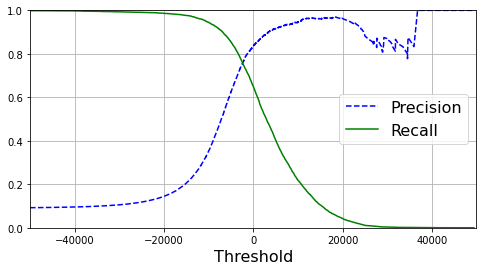

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# using matplot lib to plot precision and recall as functions of the threshold

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "g-", label='Recall')
    #plt.xlim(-45000, 45000)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])  # first and secondn are the x limits, third and fourth are the y limits
    #plt.gcf().set_size_inches(10, 5)
    [...]

plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Note that the precision may sometimes go down when threshold increases

Another way to analyze precision-recall tradeoff is just plotting precision vs recall directly

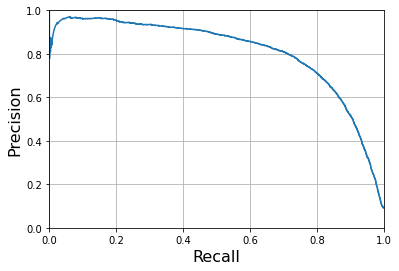

<Figure size 720x288 with 0 Axes>

In [23]:
plt.plot(recalls, precisions)  # IMPROVE ...
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.axis([0,1,0,1])
plt.grid(True)
plt.figure(figsize=(10,4))
plt.show()

Precision starts to fall sharply at around 80% recall\
We might choose a threshold before that point, for example at around 60% recall

### Suppose we want 90% precision
looking at previous graph we see that we should aim for a threshold at around 8000

In [24]:
# choosing threshold which ensures 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  
print(threshold_90_precision)
# argmax will give the first index of the maximum value which in this case is True

# make predictions on training set for now
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90)
# check precision and recall
ps = precision_score(y_train_5, y_train_pred_90)
rs = recall_score(y_train_5, y_train_pred_90)
print(f'precision score --> {ps}')
print(f'recall score --> {rs}')

3370.019499143958
[False False False ...  True False False]
precision score --> 0.9000345901072293
recall score --> 0.4799852425751706


As we saw, it is easy to create a classifier with any precision.

## The ROC Curve
it plots true positive rate (recall/sensitivity) vs false positive rate (1 - specificity),\
where fpr is the ratio of negative instances classified as positives,\
while specificity is the tnr namely the ratio of negative instances correctly classified as negative.

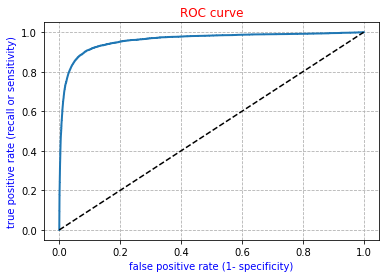

In [25]:
from sklearn.metrics import roc_curve  # it plots FPR (1 - specificity) vs TPR (sensitivity or recall) 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)  # calculating fpr and tpr for various thresholds


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
    plt.grid(linestyle='--')
    plt.title("ROC curve", color='red')
    plt.xlabel("false positive rate (1- specificity)", color='blue')
    plt.ylabel("true positive rate (recall or sensitivity)", color='blue')
    [...]
    
plot_roc_curve(fpr, tpr)
plt.show()

insights:
- the tradeoff is that the higher the tpr (recall), the higher the fpr (more false positives produced)
- a good classifier stays far away from the diagonal, towards the top-left corner

## ROC AUC score (area under the curve)
useful to compare classifiers

In [26]:
from sklearn.metrics import roc_auc_score

# measuring tbe area under the curve (AUC)
auc = roc_auc_score(y_train_5, y_scores)
print(f'AUC is {auc}')

AUC is 0.9604938554008616


a perfect classifier will have auc equal to 1, while a purely random classifier will have it equal to 0.5

### What to use between ROC curve and Precision/Recall curve?
use PR curve when a) positive class is rare and b) when caring more about fp than fn.\
Otherwise, ROC curve.

# Random Forest Classifier

In [27]:
from sklearn.ensemble import RandomForestClassifier


# training now a Random Forest in order to compare ROC and AUC to those of the SGD
# no decision function, instead:
forest_clf = RandomForestClassifier(random_state=42)
# the following calculates, for each instance, the probability of being a not 5 or a 5
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]  # score = prob of positive class (column 1)

# we can use the probabilities as scores for the roc curve
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

### comparing RF and SGD ROC curves

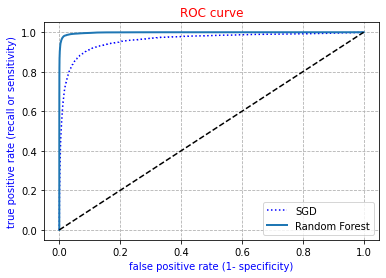

In [28]:
# ready to plot the ROC curve, we can compare to previous one also
plt.plot(fpr, tpr, 'b:', label='SGD')  # this one is the previous, namely the results of the SGD classifier
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")  # last parameter is the label which by default is set to None
plt.legend(loc='lower right')
plt.show()

In [29]:
# measuring the AUC
auc = roc_auc_score(y_train_5, y_scores_forest)
print('AUC {}'.format(auc))

AUC 0.9983436731328145


We see that RF performs even better, the AUC is greater as the curve is closer to the top-left corner than the SGD one.

In [30]:
# measuring precision and recall
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

ps_forest = precision_score(y_train_5, y_train_pred_forest)
print('random forest precision score is ', ps_forest)

rs_forest = recall_score(y_train_5, y_train_pred_forest)
print('random forest recall score is ', rs_forest)

random forest precision score is  0.9905083315756169
random forest recall score is  0.8662608374838591


We have trained a binary classifier, chosen appropriate metrics, evaluated through cross validation,\
selected the precision-recall tradeoff, used ROC and ROC AUC to compare models.

# MULTICLASS CLASSIFICATION

model that is able to distinguish between more than two classes. 
Some algorithms such as Logistic Regression, Random Forest, Naive Bayes, are able to do it natively.
Others such as SGD and SVMs are binary classifiers.

OvR strategy involves here training 10 binary classifiers (0 detector, 1 detector, 2 detector, ... , 9 detector)
then choosing the highest decision score to classify the image.

OvO strategy is training a binary classifier for each pair of digits (0 or 1 classifier, ...) but this means
training (for our dataset) 45 binary classifiers (N x (N-1)/2) = (10 x 4.5).
Then when classifying a new image, the image will go through all 45 classifiers and the class that wins
most duels will be selected.

When trying to use a binary classifier for a multiclass classification problem, Scikit learn automatically
runs OvR or OvO

## Support Vector Machine Classifier

In [31]:
from sklearn.svm import SVC

svm_cl = SVC()
svm_cl.fit(X_train, y_train)  # y_train and not y_train_5 anymore !
svm_cl.predict([some_digit])  # some_digit is still the first instance which is a 5

array([5], dtype=uint8)

### accessing decision scores for first instance

In [32]:
# now the SVC was trained on the training set but using the original target classes 0-9 and not 5-versus-all
# OvO was automatically used here (trained 45 classifiers and selected class that won most duels)
# OvR usually is preferred but some algorithms such as SVMs scale poorly with training size, so OvO is preferred then

# we can check the 10 scores per instance, in this case relative to the first instance
# each score represents approximately the number of won duels
some_digit_scores = svm_cl.decision_function([some_digit])
print(some_digit_scores)  # the highest score will be at index 5 which corresponds to number 5

# double check
print(np.argmax(some_digit_scores))  # we get the index of the maximum score
# then we use the index to access the class
print(svm_cl.classes_[5])  # when a classifier is trained, it stores the list of target classes within that attribute

# in this case the index and the class are the same number but it is just a coincidence !

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
5


### forcing OvR instead of OvO and viceversa

In [33]:
# there is a way to force Scikit to use the OvR instead of OvO and viceversa
# in this case since SVM automatically used OvO, we want to use OvR instead, namely training 10 binary classifiers in total
# which means training one classifier per digit (0-not 0, 1-not 1, etc.)

from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())  # the classifier gets passed in the constructor of the instance
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])  # now predicting the class of the first instance 

array([5], dtype=uint8)

In [34]:
len(ovr_clf.estimators_)  # 10 trained binary classifiers

10

## SGD Classifier

In [35]:
# now training a SGD classifier  -- > note: on the book it does not create a new instance !
sgd_clf = SGDClassifier(random_state=43)
sgd_clf.fit(X_train, y_train)  # instance was created previously
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

### accessing decision score assigned to each class by SGD Classifier

In [36]:
# this time Scikit learn used OvR, we can access the score assigned to each class for the first instance
sgd_clf.decision_function([some_digit])

array([[-33088.79384069, -27918.7618197 , -12448.51881789,
          -185.8380577 , -27615.83846365,   6859.76366877,
        -24000.69970261, -11544.65996835,  -5204.36251823,
        -10775.95441337]])

## Evaluate Accuracy through cross validation

In [37]:
# evaluating the classifier with cross-validation

# th following will return a score for each test fold
# 3-fold was used so there will be 3 test folds
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
# if I used a random classifier, I would get a much lower accuracy (about 10%)

array([0.8702 , 0.88485, 0.88725])

### Scaling inputs to improve accuracy

In [38]:
# scaling the inputs to get better accuracy
from sklearn.preprocessing import StandardScaler  # z = (x - u) / s   namely removing mean and using unit variance

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')
# same as before but scores increase now due to standardization

array([0.89935, 0.89195, 0.89845])

# Error Analysis

In [39]:
# ERROR ANALYSIS 
# make predictions and look at confusion matrix

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5555,    0,   21,    6,    8,   52,   35,    6,  239,    1],
       [   0, 6400,   36,   24,    4,   46,    4,    7,  211,   10],
       [  27,   29, 5222,   94,   72,   25,   64,   36,  383,    6],
       [  21,   16,  117, 5227,    2,  209,   25,   40,  403,   71],
       [  10,   14,   46,    9, 5190,   11,   35,   25,  339,  163],
       [  26,   15,   28,  163,   54, 4447,   74,   15,  541,   58],
       [  30,   15,   40,    3,   43,   97, 5551,    5,  133,    1],
       [  19,   10,   50,   30,   50,   15,    3, 5697,  190,  201],
       [  17,   65,   45,   93,    3,  131,   25,   10, 5423,   39],
       [  25,   18,   30,   67,  117,   35,    1,  178,  395, 5083]],
      dtype=int64)

### image representation of the confusion matrix

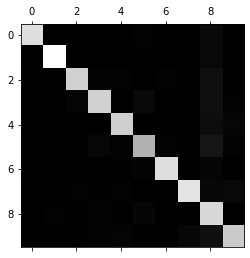

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

# Note: rows=actual classes and columns=predicted classes
# since images are mostly on the diagonal, it means most images were classified correctly
# in the 8 columns you can see lighter squares, which means many images were misclassified as 8 (mainly 2-3-4-5)
# the 5-5 square is slightly darker which might mean 1) there are fewer 5s and 2) model does not recognize well 5s

# the higher the value of the square, the lighter the square

## getting error rates instead of absolute error

In [41]:
# next step is dividing each value in the matrix by the number of images in the corresponding class
# this way we can compare error rates instead of absolute number of errors
# absolute number of errors would make abundant classes look unfairly bad

row_sums = conf_mx.sum(axis=1, keepdims=True)  # sums of each actual class
#print(row_sums)
norm_conf_mx = conf_mx / row_sums
#print(norm_conf_mx)

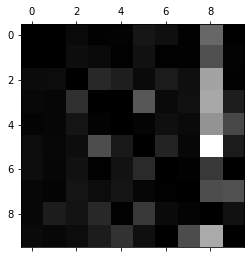

In [42]:
# filling the diagonal with zeros in order to focus only on errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# now type of errors are more clear
# for example column 8 is brighter than others, which means many not-8 obs got misclassified as 8s
# for example a lot of 5s were classified as 8 (lots of false 8s)
# also, a lot of 5s were classified as 3s, and a lot of 3s as 5s (they get confused in general)
# also 2s and 3s got confused several times

insights:
- efforts should spent on improving 8s classification \
    (e.g. by gathering more not 8s data that look like 8s, in order to make the model distinguish them)
- make some pattern like closed loops stand out more through preprocessing

### Individual Error Analysis (time-consuming): focusing on 3s and 5s classifications

In [43]:
# focus on 3s and 5s by plotting examples

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # indexes of the respected conditions are passed into the list
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# X aa will be the obs of 3s that get correctly classified
# X ab will be the obs of 3s that get classified as 5s
# X ba will be the obs of 5s that get classified as 3s
# X bb will be the obs of 5s that get correctly classified


# for example if I print X_ba I will see that the first observation is in that set
# indeed if I print y_train_pred[0] I get 3, which means that the first prediction was wrong (3 instead of 5)

# plt.figure(figsize=(8,8))

# plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
# plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
# plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
# plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# plt.show()  # NOT WORKING

# there will be 5 blocks: on the left all obs classified as 3s and on the right as 5s
# the upper left and bottom right blocks will be correct classifications
# the upper right will be misclassifications of 3s as 5s
# the bottom left will be misclassifications of 5s as 3s

# on many observations we can see that the model did not perform well: they were clearly 3s or 5s but were confused
# the reason is that we used a linear model: SGD
# the linear model assigns a weight per class to each pixel; 5s and 3s vary only for a few pixels
# more specifically, this classifier is sensitive to image shifting/rotation

# Multilabel Classification
it outputs multiple binary tags

In [44]:
# MULTILABEL CLASSIFICATION

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]  # array containing two target labels for each digit image
# the c_ concatenates each pair of element in the two passed lists

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])  # predicting if the first observation (a 5) is >= 7 and odd

array([[False,  True]])

## Evaluating multilabel classifier

In [45]:
# evaluate multilabel classifier by measuring F1 score for each individual label

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')  # assumes all labels are equally important

0.976410265560605

In [46]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')  # labels weighted according to support --> number of instances with that target label

0.9778357403921755

# Multioutput Classification
generalization of multilabel classification where each label can be multiclass

In [47]:
# MULTIOUTPUT CLASSIFICATION
# building a system that removes noise from images

noise = np.random.randint(0, 100, (len(X_train), 784))  # third argument is size/output shape (784 columns/features)
X_train_mod = X_train + noise  # original images get added noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise 
# the targe images will be the original images
y_train_mod = X_train
y_test_mod = X_test

In [49]:
# # let's train the classifier and make it clean an image
# knn_clf.fit(X_train_mod, y_train_mod)
# some_index = 0
# clean_digit = knn_clf.predict([X_test_mod[some_index]])  # need some_index value
# plot_digit(clean_digit)

## Aiming at over 97 % Accuracy

## K-Neighbors Classifier with Grid Search

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

grid_params = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform', 'distance'],
}

# consider adding 'metric': ['euclidean', 'manhattan']

kn = KNeighborsClassifier()

gs = GridSearchCV(kn, grid_params, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [51]:
# information
print(gs.best_params_)
print(gs.best_score_)

{'n_neighbors': 3, 'weights': 'distance'}
0.9693333333333333


In [53]:
from sklearn.metrics import accuracy_score


best_model = gs.best_estimator_
final_pred = best_model.predict(X_test)
# getting accuracy
acc = accuracy_score(y_test, final_pred)
print('Accuracy is {}'.format(acc*100))

Accuracy is 97.17


#### The K-Neighbors Classifier improved with hyperparameter tuning allowed to get over 97 % accuracy.